Ref:
- Starter kit : https://www.kaggle.com/michaelapers/the-plasticc-astronomy-starter-kit
- Neural net for timeseries classification : https://www.kaggle.com/meaninglesslives/simple-neural-net-for-time-series-classification
- Classification demo : https://www.kaggle.com/michaelapers/the-plasticc-astronomy-classification-demo

**The PLAsTiCC Challenge: Classifying Astronomical Sources with Light Curves**

PLAsTiCC is based on a simulation of the light curves that LSST can expect to collect (it doesn't exist yet, so we can't give you real LSST data!). These light curves have realistic time-sampling and noise properties, as well as realistic astrophysical effects for a variety of the sources in the variability tree.
These sources, even closely related classes, can have light curves that look quite different from each other.
You saw that different kinds of supernovae have different spectra. This also means that they'll have different light curves.
Different rise and fall times, different absolute energies, a different structure of bumps and wiggles.

Because the characteristic times that we conduct our observations on is a day (we can't observe when the sun is up after all!), we measure time in units of decimal day.
The specific time format we will use in PLAsTiCC is called the Modified Julian Date (MJD) - simply the number of decimal days from midnight on November 17, 1858.

If you want another time format like UNIX time (which counts decimal seconds from a reference date of Jan 1st, 1970), then it's easy to convert between the two.
The UNIX epoch in MJD is 40587 (or JD 2440587.5), so you'd use:
UNIX time=(MJD−40587)×86400, where 86400 is the number of seconds in 24 hours.

**Loading libraries**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier
import itertools
import pickle, gzip
import glob
from sklearn.preprocessing import StandardScaler

from collections import Counter, OrderedDict
from operator import itemgetter
from astropy.table import Table
import multiprocessing
from cesium.time_series import TimeSeries
import cesium.featurize as featurize
from tqdm import tnrange, tqdm_notebook
import sklearn 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

C:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.__version__

'1.1.2'

## Keras version

### Extracting features from train set

In [3]:
gc.enable()

train = pd.read_csv('training_set.csv')
train['flux_ratio_sq'] = np.power(train['flux'] / train['flux_err'], 2.0)
train['flux_by_flux_ratio_sq'] = train['flux'] * train['flux_ratio_sq']

aggs = {
    'mjd': ['min', 'max', 'size'],
    'passband': ['min', 'max', 'mean', 'median', 'std'],
    'flux': ['min', 'max', 'mean', 'median', 'std','skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std','skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum','skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

agg_train = train.groupby('object_id').agg(aggs)
new_columns = [
    k + '_' + agg for k in aggs.keys() for agg in aggs[k]
]
agg_train.columns = new_columns
agg_train['mjd_diff'] = agg_train['mjd_max'] - agg_train['mjd_min']
agg_train['flux_diff'] = agg_train['flux_max'] - agg_train['flux_min']
agg_train['flux_dif2'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_mean']
agg_train['flux_w_mean'] = agg_train['flux_by_flux_ratio_sq_sum'] / agg_train['flux_ratio_sq_sum']
agg_train['flux_dif3'] = (agg_train['flux_max'] - agg_train['flux_min']) / agg_train['flux_w_mean']

del agg_train['mjd_max'], agg_train['mjd_min']
agg_train.head()

del train
gc.collect()

7

In [9]:
agg_train.head()

,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,flux_median,...,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,mjd_diff,flux_diff,flux_dif2,flux_w_mean,flux_dif3
object_id,,,,,,,,,,,,,,,,,,,,,
615,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,-89.477524,...,0.946023,2.929669e+06,0.812722,-9.601766e+08,-1.414322,873.7903,1761.066406,-14.306331,-327.742307,-5.373326
713,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,-0.873033,...,0.171429,5.886068e+03,3.439423,-2.875087e+04,-3.454554,848.8198,29.506064,-20.730002,-4.884564,-6.040676
730,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,0.409172,...,0.069697,4.124452e+03,5.480405,1.046502e+05,5.989138,853.8455,66.469870,29.315018,25.373110,2.619697
745,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,1.035895,...,0.173789,9.416165e+04,9.611274,1.439125e+07,11.141069,853.7060,236.289675,26.521968,152.835617,1.546038
1124,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,1.141288,...,0.173295,3.432418e+04,7.868462,3.015599e+06,7.908174,873.7903,160.143942,22.411225,87.856390,1.822792


### Merging extracted features with meta data

In [7]:
meta_train = pd.read_csv('training_set_metadata.csv')
meta_train.head()

full_train = agg_train.reset_index().merge(
    right=meta_train,
    how='outer',
    on='object_id'
)

if 'target' in full_train:
    y = full_train['target']
    del full_train['target']
classes = sorted(y.unique())

# Taken from Giba's topic : https://www.kaggle.com/titericz
# https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
# with Kyle Boone's post https://www.kaggle.com/kyleboone
class_weight = {
    c: 1 for c in classes
}
for c in [64, 15]:
    class_weight[c] = 2

print('Unique classes : ', classes)

Unique classes :  [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]


In [8]:
full_train.head()

,object_id,mjd_size,passband_min,passband_max,passband_mean,passband_median,passband_std,flux_min,flux_max,flux_mean,...,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv
0,615,352,0,5,2.457386,2.0,1.720797,-1100.440063,660.626343,-123.096998,...,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017
1,713,350,0,5,2.400000,2.0,1.746056,-14.735178,14.770886,-1.423351,...,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007
2,730,330,0,5,2.336364,2.0,1.758750,-19.159811,47.310059,2.267434,...,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021
3,745,351,0,5,2.378917,2.0,1.747328,-15.494463,220.795212,8.909206,...,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007
4,1124,352,0,5,2.457386,2.0,1.720797,-16.543753,143.600189,7.145702,...,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024


In [10]:
full_train.shape

(7848, 39)

In [11]:
if 'object_id' in full_train:
    oof_df = full_train[['object_id']]
    del full_train['object_id'], full_train['distmod'], full_train['hostgal_specz']
    del full_train['ra'], full_train['decl'], full_train['gal_l'],full_train['gal_b'],full_train['ddf']
    
    
train_mean = full_train.mean(axis=0)
full_train.fillna(train_mean, inplace=True)

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

### Standard Scaling the input (imp.)

In [12]:
full_train_new = full_train.copy()
ss = StandardScaler()
full_train_ss = ss.fit_transform(full_train_new)

### Deep Learning

In [13]:
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.utils import to_categorical
import tensorflow as tf
from keras import backend as K
import keras
from keras import regularizers
from collections import Counter
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type

In [14]:
def mywloss(y_true,y_pred):  
    yc=tf.clip_by_value(y_pred,1e-15,1-1e-15)
    loss=-(tf.reduce_mean(tf.reduce_mean(y_true*tf.log(yc),axis=0)/wtable))
    return loss

def multi_weighted_logloss(y_ohe, y_p):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set 
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

**Defining simple model in Keras:**

In [15]:
K.clear_session()
def build_model(dropout_rate=0.25,activation='relu'):
    start_neurons = 512
    # create model
    model = Sequential()
    model.add(Dense(start_neurons, input_dim=full_train_ss.shape[1], activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//2,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//4,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(start_neurons//8,activation=activation))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate/2))
    
    model.add(Dense(len(classes), activation='softmax'))
    return model

In [16]:
unique_y = np.unique(y)
class_map = dict()
for i,val in enumerate(unique_y):
    class_map[val] = i
        
y_map = np.zeros((y.shape[0],))
y_map = np.array([class_map[val] for val in y])
y_categorical = to_categorical(y_map)

**Calculating the class weights:**

In [17]:
y_count = Counter(y_map)
wtable = np.zeros((len(unique_y),))
for i in range(len(unique_y)):
    wtable[i] = y_count[i]/y_map.shape[0]

In [18]:
def plot_loss_acc(history):
    plt.plot(history.history['loss'][1:])
    plt.plot(history.history['val_loss'][1:])
    plt.title('model loss')
    plt.ylabel('val_loss')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['train','Validation'], loc='upper left')
    plt.show()

**Training:**

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


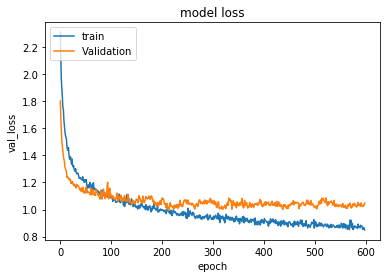

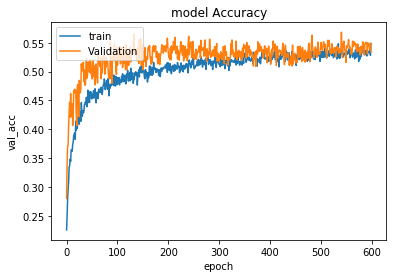

Loading Best Model
1.0105069818078134


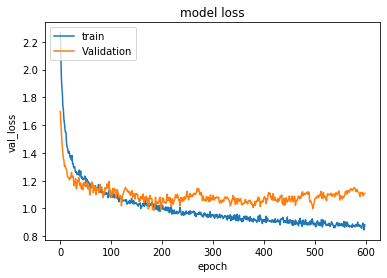

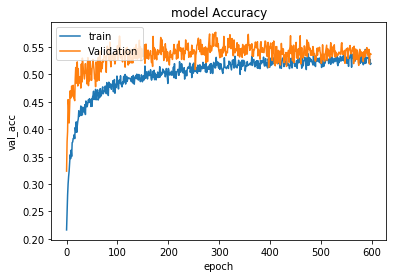

Loading Best Model
1.0025046667375626


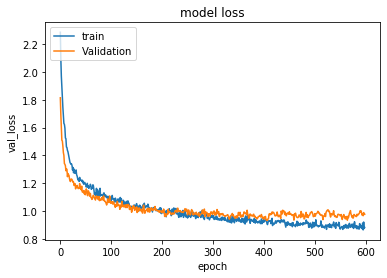

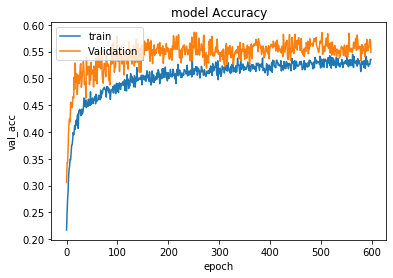

Loading Best Model
0.9496937156811754


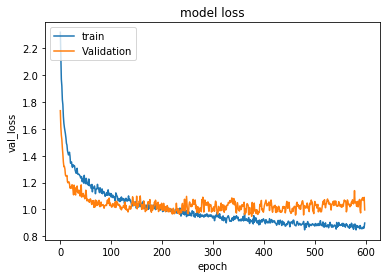

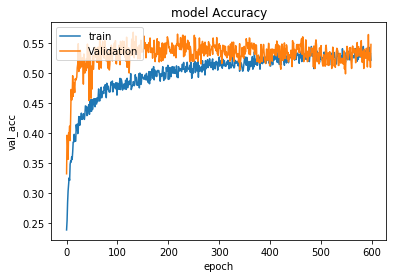

Loading Best Model
1.020210688643567


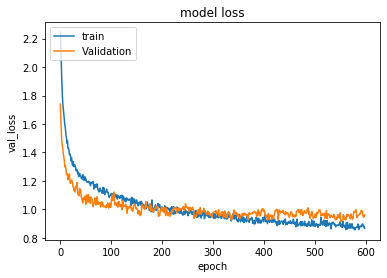

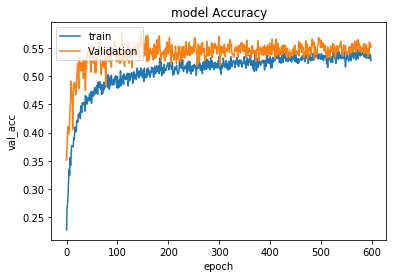

Loading Best Model
0.9231577135704929
MULTI WEIGHTED LOG LOSS : 0.98055 


In [19]:
clfs = []
oof_preds = np.zeros((len(full_train_ss), len(classes)))
epochs = 600
batch_size = 100
for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint("./keras.model",monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    x_train, y_train = full_train_ss[trn_], y_categorical[trn_]
    x_valid, y_valid = full_train_ss[val_], y_categorical[val_]
    
    model = build_model(dropout_rate=0.5,activation='tanh')    
    model.compile(loss=mywloss, optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,shuffle=True,verbose=0,callbacks=[checkPoint])       
    
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict_proba(x_valid,batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict_proba(x_valid,batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

**Confusion matrix:**

In [20]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [21]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds,axis=-1))
np.set_printoptions(precision=2)

In [23]:
sample_sub = pd.read_csv('sample_submission.csv')
class_names = list(sample_sub.columns[1:-1])
del sample_sub;gc.collect()

5784

Normalized confusion matrix
[[7.48e-01 0.00e+00 5.30e-02 0.00e+00 0.00e+00 2.65e-02 0.00e+00 0.00e+00
  1.06e-01 0.00e+00 0.00e+00 0.00e+00 6.62e-02 0.00e+00]
 [2.02e-03 3.52e-01 4.04e-03 6.87e-02 1.01e-01 0.00e+00 6.87e-02 5.25e-02
  0.00e+00 1.96e-01 1.01e-02 1.13e-01 0.00e+00 3.23e-02]
 [1.08e-02 0.00e+00 9.58e-01 0.00e+00 0.00e+00 1.08e-03 0.00e+00 0.00e+00
  4.33e-03 0.00e+00 0.00e+00 0.00e+00 2.60e-02 0.00e+00]
 [2.51e-03 1.51e-01 0.00e+00 1.85e-01 1.48e-01 8.38e-04 1.27e-01 5.95e-02
  4.19e-03 1.37e-01 9.22e-03 1.42e-01 0.00e+00 3.35e-02]
 [0.00e+00 1.80e-01 0.00e+00 5.46e-02 2.40e-01 0.00e+00 1.04e-01 3.83e-02
  0.00e+00 1.86e-01 0.00e+00 1.80e-01 0.00e+00 1.64e-02]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.67e-01 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.33e-02 0.00e+00]
 [0.00e+00 1.67e-01 0.00e+00 8.26e-02 1.24e-01 0.00e+00 1.43e-01 9.30e-02
  2.07e-03 2.89e-01 2.07e-03 8.47e-02 0.00e+00 1.24e-02]
 [9.80e-03 1.96e-02 0.00e+00 0.00e+00 1.96e-02 0.00e+00

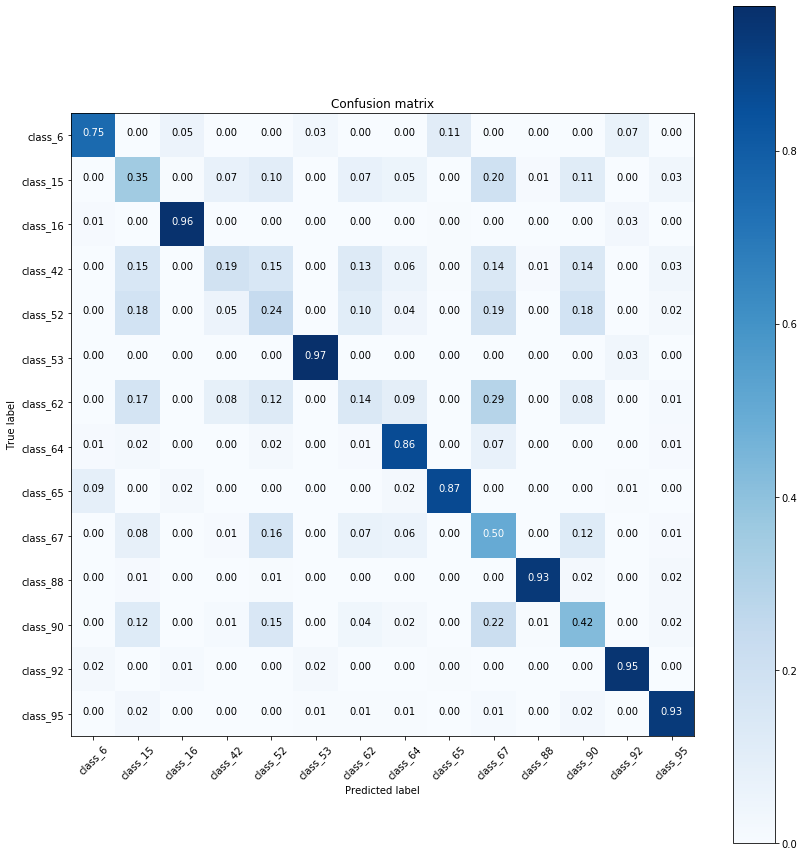

In [24]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(12,12))
foo = plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix')

## Random forest version

In [3]:
pbmap = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'Y')])

# it also helps to have passbands associated with a color
pbcols = OrderedDict([(0,'blueviolet'), (1,'green'), (2,'red'),\
                      (3,'orange'), (4, 'black'), (5, 'brown')])

pbnames = list(pbmap.values())

In [4]:
metafilename = 'training_set_metadata.csv'
metadata = Table.read(metafilename, format='csv')
nobjects = len(metadata)
metadata

object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
int32,float64,float64,float64,float64,int32,float64,float64,float64,float64,float64,int32
615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,nan,0.017,92
713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
730,33.574219,-6.579593,170.455585,-61.548219,1,0.232,0.2262,0.0157,40.2561,0.021,42
745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90
1227,35.683594,-5.379379,171.992947,-59.253501,1,0.0,0.0,0.0,nan,0.02,65
1598,347.84671,-64.760857,318.929827,-49.143596,1,0.1352,0.182,0.0304,39.7279,0.019,90
1632,348.595886,-63.07262,320.023289,-50.71306,1,0.6857,0.7014,0.01,43.1524,0.021,42
1920,149.414062,3.433834,234.919132,42.24555,1,0.3088,0.3229,0.336,41.1401,0.027,90


Since we can split between extragalactic and galactic sources on the basis of redshift, you may choose to build separate classifiers for the two sets.
Or you might split the deep-drilling fields (DDF i.e. ddf_bool = 1) up from the wide-fast-deep fields (WFD i.e. ddf_bool = 0).

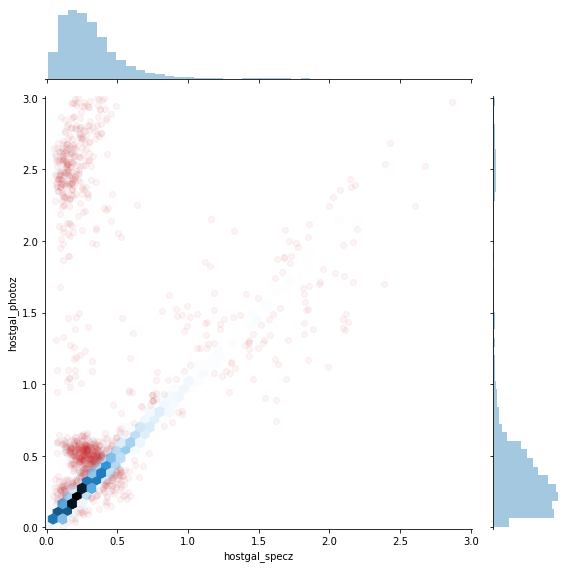

In [5]:
extragal = metadata['hostgal_specz'] != 0.
g = sns.jointplot(metadata['hostgal_specz'][extragal],\
              metadata['hostgal_photoz'][extragal], kind='hex',\
                  xlim=(-0.01, 3.01), ylim=(-0.01,3.01), height=8)

outliers = np.abs(metadata['hostgal_specz'] - metadata['hostgal_photoz']) > 0.1
fig = g.fig
fig.axes[0].scatter(metadata['hostgal_specz'][outliers],\
                    metadata['hostgal_photoz'][outliers], color='C3', alpha=0.05)
fig.tight_layout()

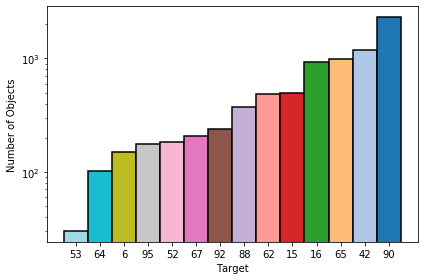

In [6]:
counts = Counter(metadata['target'])
labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))
fig, ax = plt.subplots()

cmap = plt.cm.tab20
nlines = len(labels)
classcolor =  list(cmap(np.linspace(0,1,nlines)))[::-1]

# we'll create a mapping between class and color
classcolmap = dict(zip(labels, classcolor))

indexes = np.arange(nlines)
width = 1
ax.bar(indexes, values, width, edgecolor='k',\
       linewidth=1.5, tick_label=labels, log=True, color=classcolor)
ax.set_xlabel('Target')
ax.set_ylabel('Number of Objects')
fig.tight_layout()

You can see the class distribution in the training set is imbalanced. This reflects reality. The Universe doesn't produce all kinds of events at equal rates, and even if it did, some events are fainter than others, so we'd naturally find fewer of them than bright events.

Next, we'll read the light curve data. All the objects in the training set are in a single file:

In [7]:
lcfilename = 'training_set.csv'
lcdata = Table.read(lcfilename, format='csv')
lcdata

object_id,mjd,passband,flux,flux_err,detected
int32,float64,int32,float64,float64,int32
615,59750.4229,2,-544.810303,3.622952,1
615,59750.4306,1,-816.434326,5.55337,1
615,59750.4383,3,-471.385529,3.801213,1
615,59750.445,4,-388.984985,11.395031,1
615,59752.407,2,-681.858887,4.041204,1
615,59752.4147,1,-1061.457031,6.472994,1
615,59752.4224,3,-524.95459,3.552751,1
615,59752.4334,4,-393.480225,3.599346,1
615,59752.4435,5,-355.88678,10.421921,1


Next, we'll make a Timeseries object using the cesium python package for each lightcurve.

In [8]:
tsdict = OrderedDict()
for i in tnrange(nobjects, desc='Building Timeseries'):
    row = metadata[i]
    thisid = row['object_id']
    target = row['target']
    
    meta = {'z':row['hostgal_photoz'],\
            'zerr':row['hostgal_photoz_err'],\
            'mwebv':row['mwebv']}
    
    ind = (lcdata['object_id'] == thisid)
    thislc = lcdata[ind]

    pbind = [(thislc['passband'] == pb) for pb in pbmap]
    t = [thislc['mjd'][mask].data for mask in pbind ]
    m = [thislc['flux'][mask].data for mask in pbind ]
    e = [thislc['flux_err'][mask].data for mask in pbind ]

    tsdict[thisid] = TimeSeries(t=t, m=m, e=e,\
                        label=target, name=thisid, meta_features=meta,\
                        channel_names=pbnames )
    
del lcdata

In [9]:
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]

In [10]:
# we'll turn off warnings for a bit, because numpy can be whiny. 
import warnings
warnings.simplefilter('ignore')

In [11]:
def worker(tsobj):
    global features_to_use
    thisfeats = featurize.featurize_single_ts(tsobj,\
    features_to_use=features_to_use,
    raise_exceptions=False)
    return thisfeats

In [12]:
featurefile = f'plasticc_featuretable.npz'
if os.path.exists(featurefile):
    featuretable, _ = featurize.load_featureset(featurefile)
else:
    features_list = []
    with tqdm_notebook(total=nobjects, desc="Computing Features") as pbar:
        with multiprocessing.Pool() as pool:  
            results = pool.imap(worker, list(tsdict.values()))
            for res in results:
                features_list.append(res)
                pbar.update()
            
    featuretable = featurize.assemble_featureset(features_list=features_list,\
                              time_series=tsdict.values())
    featurize.save_featureset(fset=featuretable, path=featurefile)

In [13]:
old_names = featuretable.columns.values
new_names = ['{}_{}'.format(x, pbmap.get(y,'meta')) for x,y in old_names]
cols = [featuretable[col] for col in old_names]
allfeats = Table(cols, names=new_names)
del featuretable

We'll split the training set into two - one for training in this demo and the other for testing.

We'll do this preserving class balance in the full training set, but remember the training set might not be representative. The class balance in the training set reflects whatever we've followed up spectroscopically prior to LSST science operations starting.

In [14]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
splits = list(splitter.split(allfeats, metadata['target']))[0]
train_ind, test_ind = splits

To prevent overfitting, it's a probably a good idea to reduce the dimensionality of the dataset. We'll look at this correlation structure.

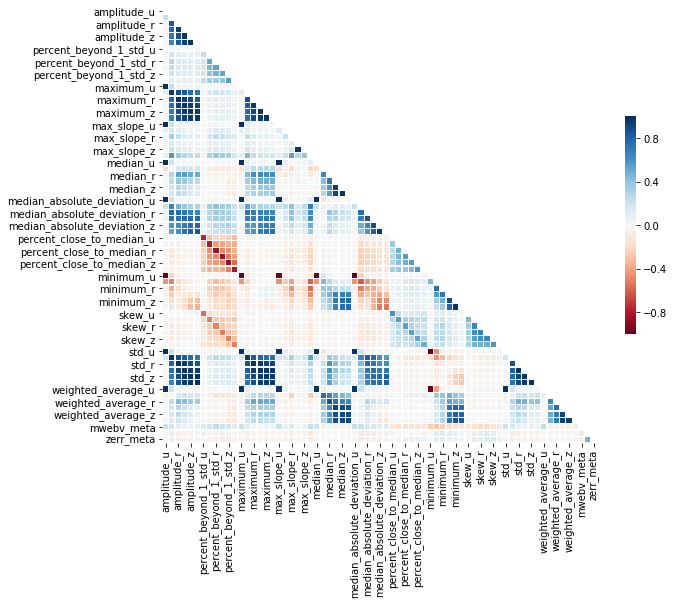

In [15]:
corr = allfeats.to_pandas().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
corr_plot = sns.heatmap(corr, mask=mask, cmap='RdBu', center=0,
                square=True, linewidths=.2, cbar_kws={"shrink": .5})

You can see some of the bands are strongly correlated with each other, so lets try to reduce the dimensionality of the dataset looking for a two effective passbands.

In [16]:
Xtrain = np.array(allfeats[train_ind].as_array().tolist())
Ytrain = np.array(metadata['target'][train_ind].tolist())

Xtest  = np.array(allfeats[test_ind].as_array().tolist())
Ytest  = np.array(metadata['target'][test_ind].tolist())

ncols = len(new_names)
npca  = (ncols  - 3)//len(pbnames)  + 3

pca = PCA(n_components=npca, whiten=True, svd_solver="full", random_state=42)
Xtrain_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)

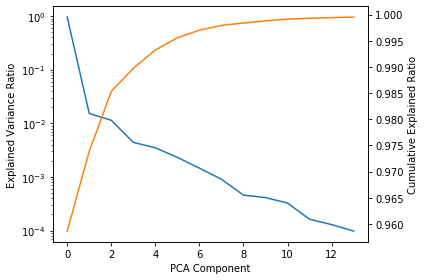

In [17]:
fig, ax = plt.subplots()
ax.plot(np.arange(npca), pca.explained_variance_ratio_, color='C0')
ax2 = ax.twinx()
ax2.plot(np.arange(npca), np.cumsum(pca.explained_variance_ratio_), color='C1')
ax.set_yscale('log')
ax.set_xlabel('PCA Component')
ax.set_ylabel('Explained Variance Ratio')
ax2.set_ylabel('Cumulative Explained Ratio')
fig.tight_layout()

In [18]:
clf = RandomForestClassifier(n_estimators=200, criterion='gini',\
                       oob_score=True, n_jobs=-1, random_state=42,\
                      verbose=1, class_weight='balanced', max_features='sqrt')

In [19]:
clf.fit(Xtrain_pca, Ytrain)
Ypred = clf.predict(Xtest_pca)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [20]:
cm = confusion_matrix(Ytest, Ypred, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

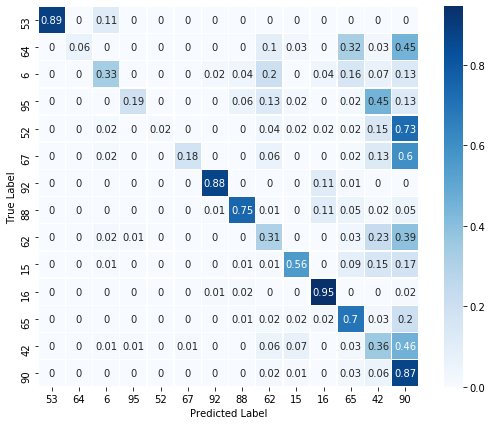

In [21]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')